In [1]:
import pandas as pd
import sqlalchemy
from matplotlib import pyplot as plt
import datetime
import copy
import numpy as np

In [2]:
db = sqlalchemy.engine.url.URL(drivername='mysql',
                            host='127.0.0.1',
                            database='sherman_1',
                            query={'read_default_file': '~/.my.cnf', 'charset':'utf8'})
engine = sqlalchemy.create_engine(db)

In [3]:
df = pd.read_sql('''
    SELECT * FROM sherman_1.calls;
''' ,engine)

In [5]:
def get_incoming_outgoing_missed(df):
    uniq_device_id = list(set(df['device_id'].tolist()))
    df_output = pd.DataFrame()
    df_incoming = pd.DataFrame()
    df_outgoing = pd.DataFrame()
    df_missed = pd.DataFrame()
    for device_id in uniq_device_id:
        df_target = df[df['device_id']==device_id]
        df_target = df_target.sort_values(by = 'timestamp', ascending = False)
        
        df_output_temp = df_target[['device_id','timestamp']]
        
        past_type = df_target['call_type'].tolist()
        past_type = past_type[1:]+[None]
        future_type = df_target['call_type'].tolist()
        future_type = [None]+future_type[:-1]
        duration = df_target['call_duration'].tolist()
        duration = [None]+duration[:-1]
        
        df_target['past_type'] = past_type
        df_target['future_type'] = future_type
        df_target['duration'] = duration
        
        

        #incoming
        df_incoming_temp = df_target[(df_target['past_type']==1)&
                                   (df_target['call_type']==2)&
                                   (df_target['future_type']==4)]
        
        df_incoming_temp['incoming_time'] = df_incoming_temp['duration']
        df_incoming_temp = df_incoming_temp[['device_id','timestamp','incoming_time']]
        
        
        #outgoing
        df_outgoing_temp = df_target[(df_target['past_type']==3)&
                                   (df_target['call_type']==2)&
                                   (df_target['future_type']==4)]
        
        df_outgoing_temp['outgoing_time'] = df_outgoing_temp['duration']
        df_outgoing_temp = df_outgoing_temp[['device_id','timestamp','outgoing_time']]
        
        
        #missing
        df_missing_temp = df_target[(df_target['call_type']==4)&
                                   (df_target['past_type']!=2)]
        
        df_missing_temp['missing_time'] = df_missing_temp['duration']
        df_missing_temp = df_missing_temp[['device_id','timestamp','missing_time']]
        
        df_output_temp = df_output_temp.merge(df_incoming_temp, on = ['device_id','timestamp'], how = 'left')
        df_output_temp = df_output_temp.fillna(0)
        
        df_output_temp = df_output_temp.merge(df_outgoing_temp, on = ['device_id','timestamp'], how = 'left')
        df_output_temp = df_output_temp.fillna(0)
        
        df_output_temp = df_output_temp.merge(df_missing_temp, on = ['device_id','timestamp'], how = 'left')
        df_output_temp = df_output_temp.fillna(0)
        
        if df_output_temp.shape[0]>0:
            df_output = pd.concat([df_output, df_output_temp], ignore_index=True)
    
    return df_output

In [ ]:
df_less = get_incoming_outgoing_missed(df)
df_less['date'] = pd.to_datetime(df_less['timestamp'],unit='ms').dt.date
df_less.head(10)

In [7]:
df_less = df_less[['device_id','date','incoming_time','outgoing_time','missing_time']]
df_less['incoming_freq'] = df_less['incoming_time'].apply(lambda x: int(x>0))
df_less['outgoing_freq'] = df_less['outgoing_time'].apply(lambda x: int(x>0))
df_less['missing_freq'] = df_less['missing_time'].apply(lambda x: int(x>0))
df_output = df_less.groupby(['device_id','date']).agg(incoming_time = ('incoming_time', np.sum),
                                                      incoming_freq = ('incoming_freq',np.sum),
                                                      outgoing_time = ('outgoing_time', np.sum),
                                                      outgoing_freq = ('outgoing_freq',np.sum),
                                                      missing_time = ('missing_time', np.sum),
                                                      missing_freq = ('missing_freq',np.sum),
                                                     )
df_output = df_output.reset_index()
df_output['incoming_freq'] = df_output['incoming_freq'].apply(lambda x: int(x))
df_output['outgoing_freq'] = df_output['outgoing_freq'].apply(lambda x: int(x))
df_output['missing_freq'] = df_output['missing_freq'].apply(lambda x: int(x))
df_output

,device_id,date,incoming_time,incoming_freq,outgoing_time,outgoing_freq,missing_time,missing_freq
0,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-19,625.0,3,24.0,2,0.0,0
1,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-20,1876.0,7,1830.0,14,1176.0,2
2,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-21,5157.0,10,803.0,3,0.0,0
3,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-22,1403.0,4,335.0,16,954.0,2
4,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-23,4783.0,6,996.0,4,0.0,0
...,...,...,...,...,...,...,...,...
2584,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-27,29.0,1,1285.0,5,0.0,0
2585,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-28,0.0,0,1795.0,3,0.0,0
2586,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-29,0.0,0,911.0,6,0.0,0
2587,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-30,13.0,1,330.0,3,0.0,0


In [8]:
df_output.to_csv("calls_cleaned.csv", index = False)

# filter 1-28

In [9]:
def find_first_day(device_id, df_cleaned):
    df_target = df_cleaned[df_cleaned['device_id']==device_id]
    return min(df_target['date'])

In [10]:
def get_1_to_28(df_cleaned):
    first_day = {device_id:find_first_day(device_id, df_cleaned) 
                 for device_id in set(df_cleaned['device_id'].tolist())
                if find_first_day(device_id, df_cleaned)>=datetime.date(year=2022,month=11,day=11)}
    df_cleaned = df_cleaned[df_cleaned['device_id'].isin(first_day)]
    df_cleaned['day'] = df_cleaned.apply(lambda x: 1+(x['date']-first_day[x['device_id']]).days, axis = 1)
    df_cleaned = df_cleaned[df_cleaned['day']<=28]
    return df_cleaned

In [11]:
df_cleaned_1_28 = get_1_to_28(df_output)
df_cleaned_1_28['device_id'].nunique()

<ipython-input-10-81973113a098>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['day'] = df_cleaned.apply(lambda x: 1+(x['date']-first_day[x['device_id']]).days, axis = 1)


81

# lineplot

In [12]:
df_plot = copy.deepcopy(df_cleaned_1_28)
#df_plot = df_plot.merge(df_group[['device_id','Group']], on = 'device_id', how = 'left')
df_plot = df_plot[['day','incoming_time','outgoing_time','missing_time','incoming_freq','outgoing_freq','missing_freq']]
df_plot = df_plot.groupby('day').mean()
df_plot = df_plot.reset_index()
df_plot


,day,incoming_time,outgoing_time,missing_time,incoming_freq,outgoing_freq,missing_freq
0,1,381.308642,372.320988,69.629630,1.543210,1.691358,0.160494
1,2,1317.125000,779.791667,121.361111,2.680556,3.222222,0.277778
2,3,1033.328571,1078.457143,167.242857,2.185714,2.942857,0.114286
3,4,757.161765,1283.558824,48.191176,2.558824,4.367647,0.220588
4,5,874.163934,975.180328,63.918033,2.262295,3.459016,0.081967
5,6,1212.881356,1044.796610,77.983051,2.203390,3.271186,0.169492
6,7,722.969231,1345.046154,198.984615,2.046154,3.707692,0.415385
7,8,1050.683333,1437.916667,92.950000,2.866667,4.083333,0.200000
8,9,852.873016,773.809524,211.460317,2.904762,3.523810,0.365079
9,10,665.578125,620.359375,73.390625,1.890625,2.500000,0.156250


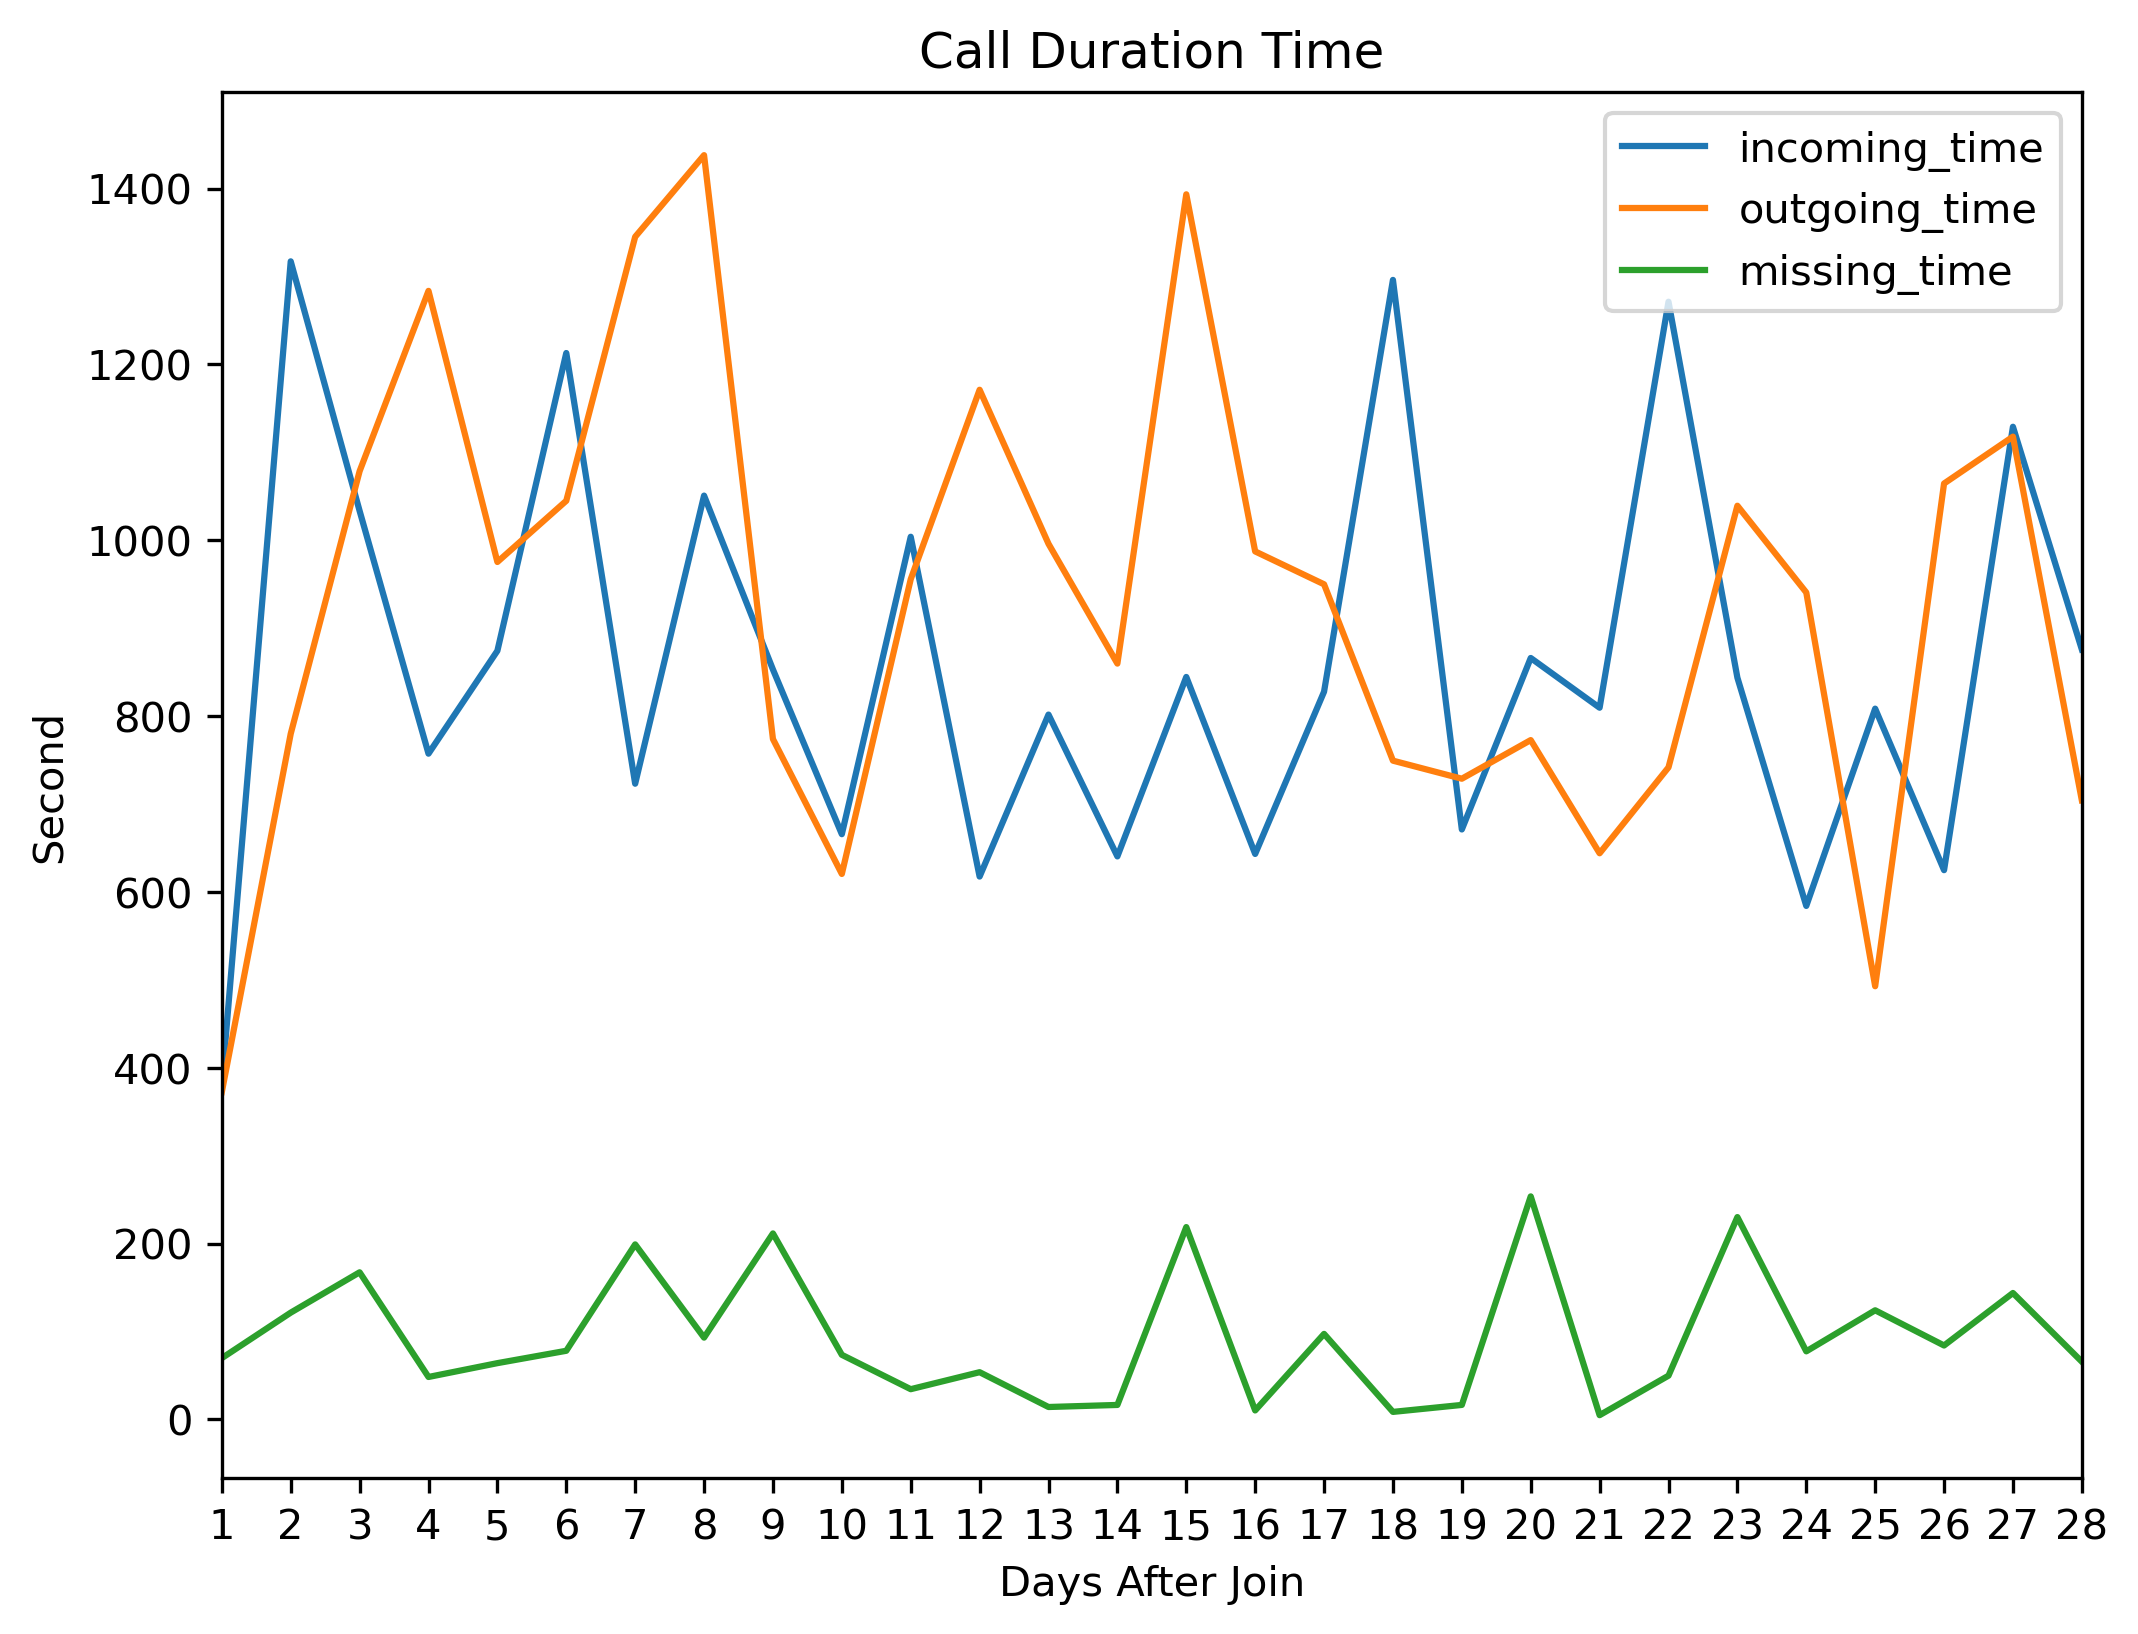

In [13]:
plt.figure(figsize=(8, 6), dpi=300)
for feature in ['incoming_time','outgoing_time','missing_time']:
    x = [i+1 for i in range(28)]
    y = df_plot[feature].tolist()
    plt.plot(x,y,label = feature)
plt.xlim(1,28)
plt.xticks([i+1 for i in range(28)],[i+1 for i in range(28)])
plt.title("Call Duration Time")
plt.xlabel("Days After Join")
plt.ylabel('Second')
plt.legend()
plt.show()

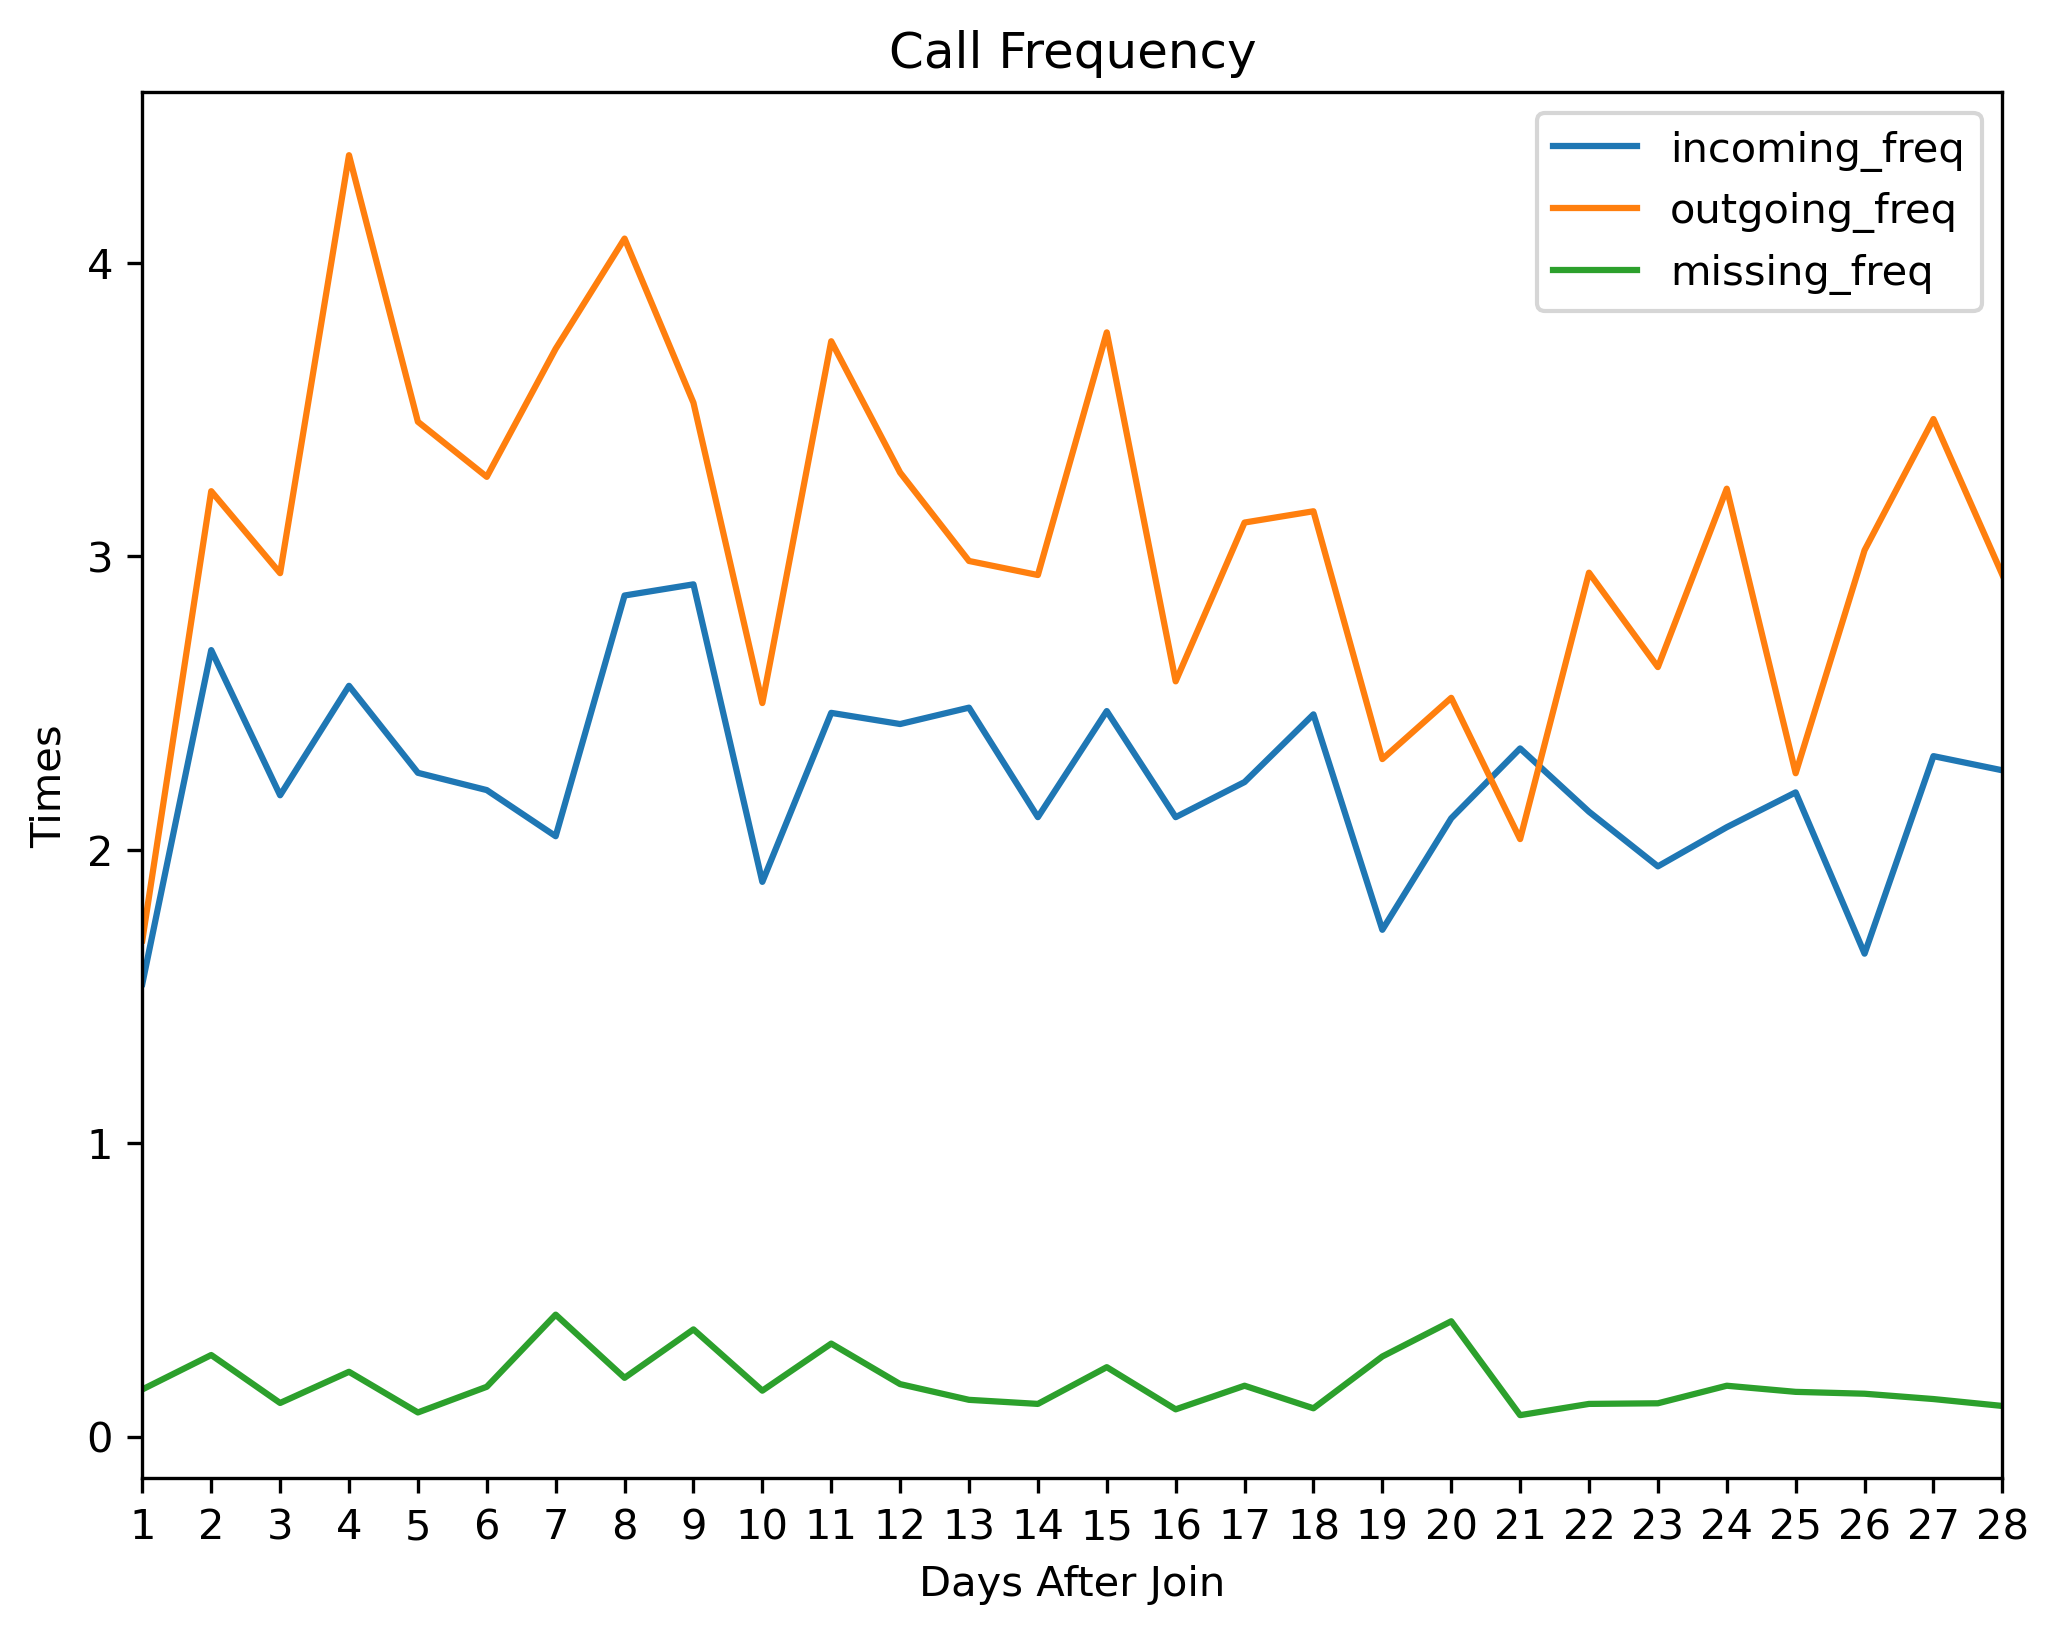

In [14]:
plt.figure(figsize=(8, 6), dpi=300)
for feature in ['incoming_freq','outgoing_freq','missing_freq']:
    x = [i+1 for i in range(28)]
    y = df_plot[feature].tolist()
    plt.plot(x,y,label = feature)
plt.xlim(1,28)
plt.xticks([i+1 for i in range(28)],[i+1 for i in range(28)])
plt.title("Call Frequency")
plt.xlabel("Days After Join")
plt.ylabel('Times')
plt.legend()
plt.show()

# group plot

In [19]:
df_id = pd.read_csv("/data/meditation/majid/tables/id.csv")
df_id = df_id.drop_duplicates('study_id')
df_id = df_id.drop('id', axis = 1)
df_id.columns = ['device_id','Study ID']
df_id



,device_id,Study ID
0,4a23c5dc-9a50-4d46-a12d-dd94ee98270f,8415477
1,f3845ba4-8702-42cf-a14f-051c46f66b61,15027959
2,ae02314b-a607-41b9-9507-28ffa1babed7,73386307
3,b460f89e-fd76-46ff-a960-989d74fcb66a,87785016
4,e5048fab-dc20-4d99-8cea-220a5a2750e0,14851895
...,...,...
70,780c9b18-72d3-4714-858d-3c91b3719155,21788465
71,a1118578-bbb4-47ef-b784-7d5bd09ad8b5,7389236
72,00e17b8a-4b0f-4230-bd26-3df2853e8916,69546645
73,029e57cb-fa0d-479d-abd2-9cb5745f219d,72690342


In [20]:
df_group = pd.read_csv('/data/meditation/majid/surveys/0.csv', skiprows=[1,2])[['Study ID','Group']]
df_group = df_id.merge(df_group, on = 'Study ID', how = 'left')
df_group

,device_id,Study ID,Group
0,4a23c5dc-9a50-4d46-a12d-dd94ee98270f,8415477,Experimental Condition
1,f3845ba4-8702-42cf-a14f-051c46f66b61,15027959,Active Control
2,ae02314b-a607-41b9-9507-28ffa1babed7,73386307,Active Control
3,b460f89e-fd76-46ff-a960-989d74fcb66a,87785016,Active Control
4,e5048fab-dc20-4d99-8cea-220a5a2750e0,14851895,Passive Control
...,...,...,...
64,780c9b18-72d3-4714-858d-3c91b3719155,21788465,Active Control
65,a1118578-bbb4-47ef-b784-7d5bd09ad8b5,7389236,Passive Control
66,00e17b8a-4b0f-4230-bd26-3df2853e8916,69546645,Experimental Condition
67,029e57cb-fa0d-479d-abd2-9cb5745f219d,72690342,Passive Control


In [16]:
df_plot = copy.deepcopy(df_cleaned_1_28)
df_plot = df_plot.merge(df_group[['device_id','Group']], on = 'device_id', how = 'left')
df_plot = df_plot[['day','Group','incoming_time','outgoing_time','missing_time','incoming_freq','outgoing_freq','missing_freq']]
df_plot = df_plot.groupby(['Group','day']).mean()
df_plot = df_plot.reset_index()
df_plot


,Group,day,incoming_time,outgoing_time,missing_time,incoming_freq,outgoing_freq,missing_freq
0,Active Control,1,406.041667,323.875000,0.541667,1.625000,1.333333,0.041667
1,Active Control,2,664.318182,372.000000,0.045455,2.045455,2.318182,0.045455
2,Active Control,3,614.636364,1051.454545,102.454545,1.909091,2.409091,0.045455
3,Active Control,4,854.875000,1429.750000,37.125000,2.562500,4.687500,0.125000
4,Active Control,5,421.500000,361.555556,0.000000,1.833333,2.388889,0.000000
...,...,...,...,...,...,...,...,...
79,Passive Control,24,493.400000,1142.666667,25.200000,2.400000,3.666667,0.066667
80,Passive Control,25,1021.923077,670.846154,103.692308,2.615385,2.769231,0.153846
81,Passive Control,26,694.285714,1295.428571,245.285714,1.642857,3.214286,0.071429
82,Passive Control,27,421.133333,1409.533333,0.000000,2.066667,3.200000,0.000000


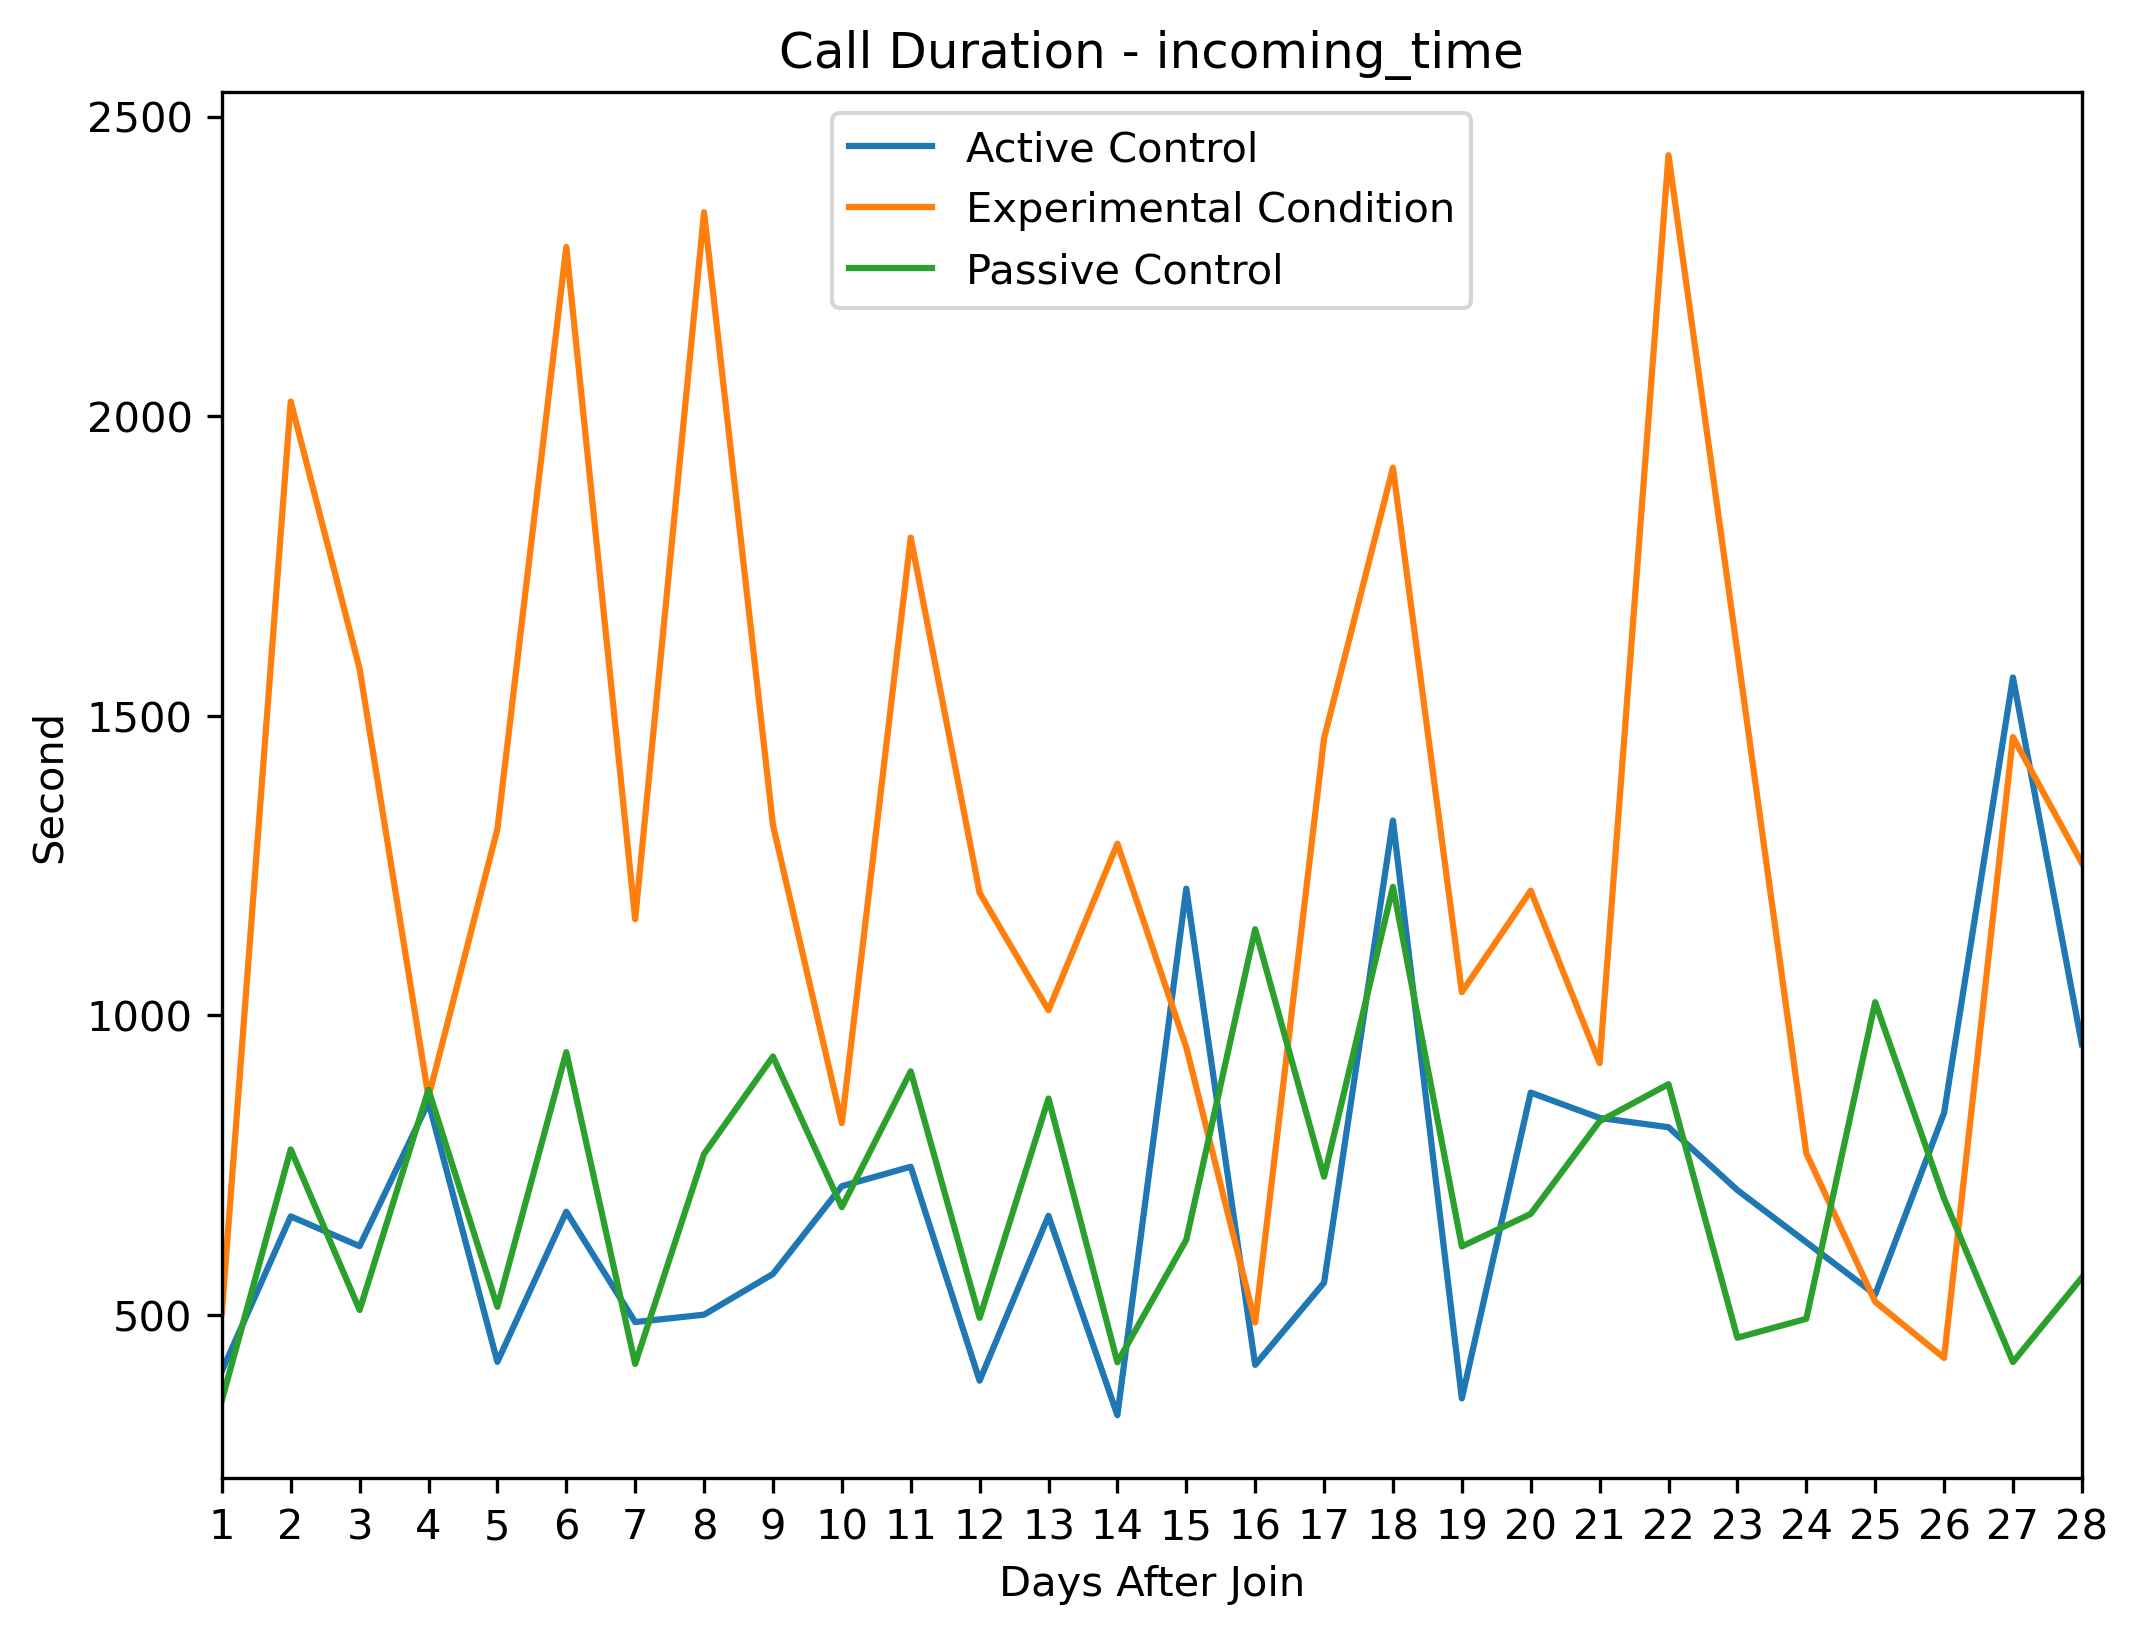

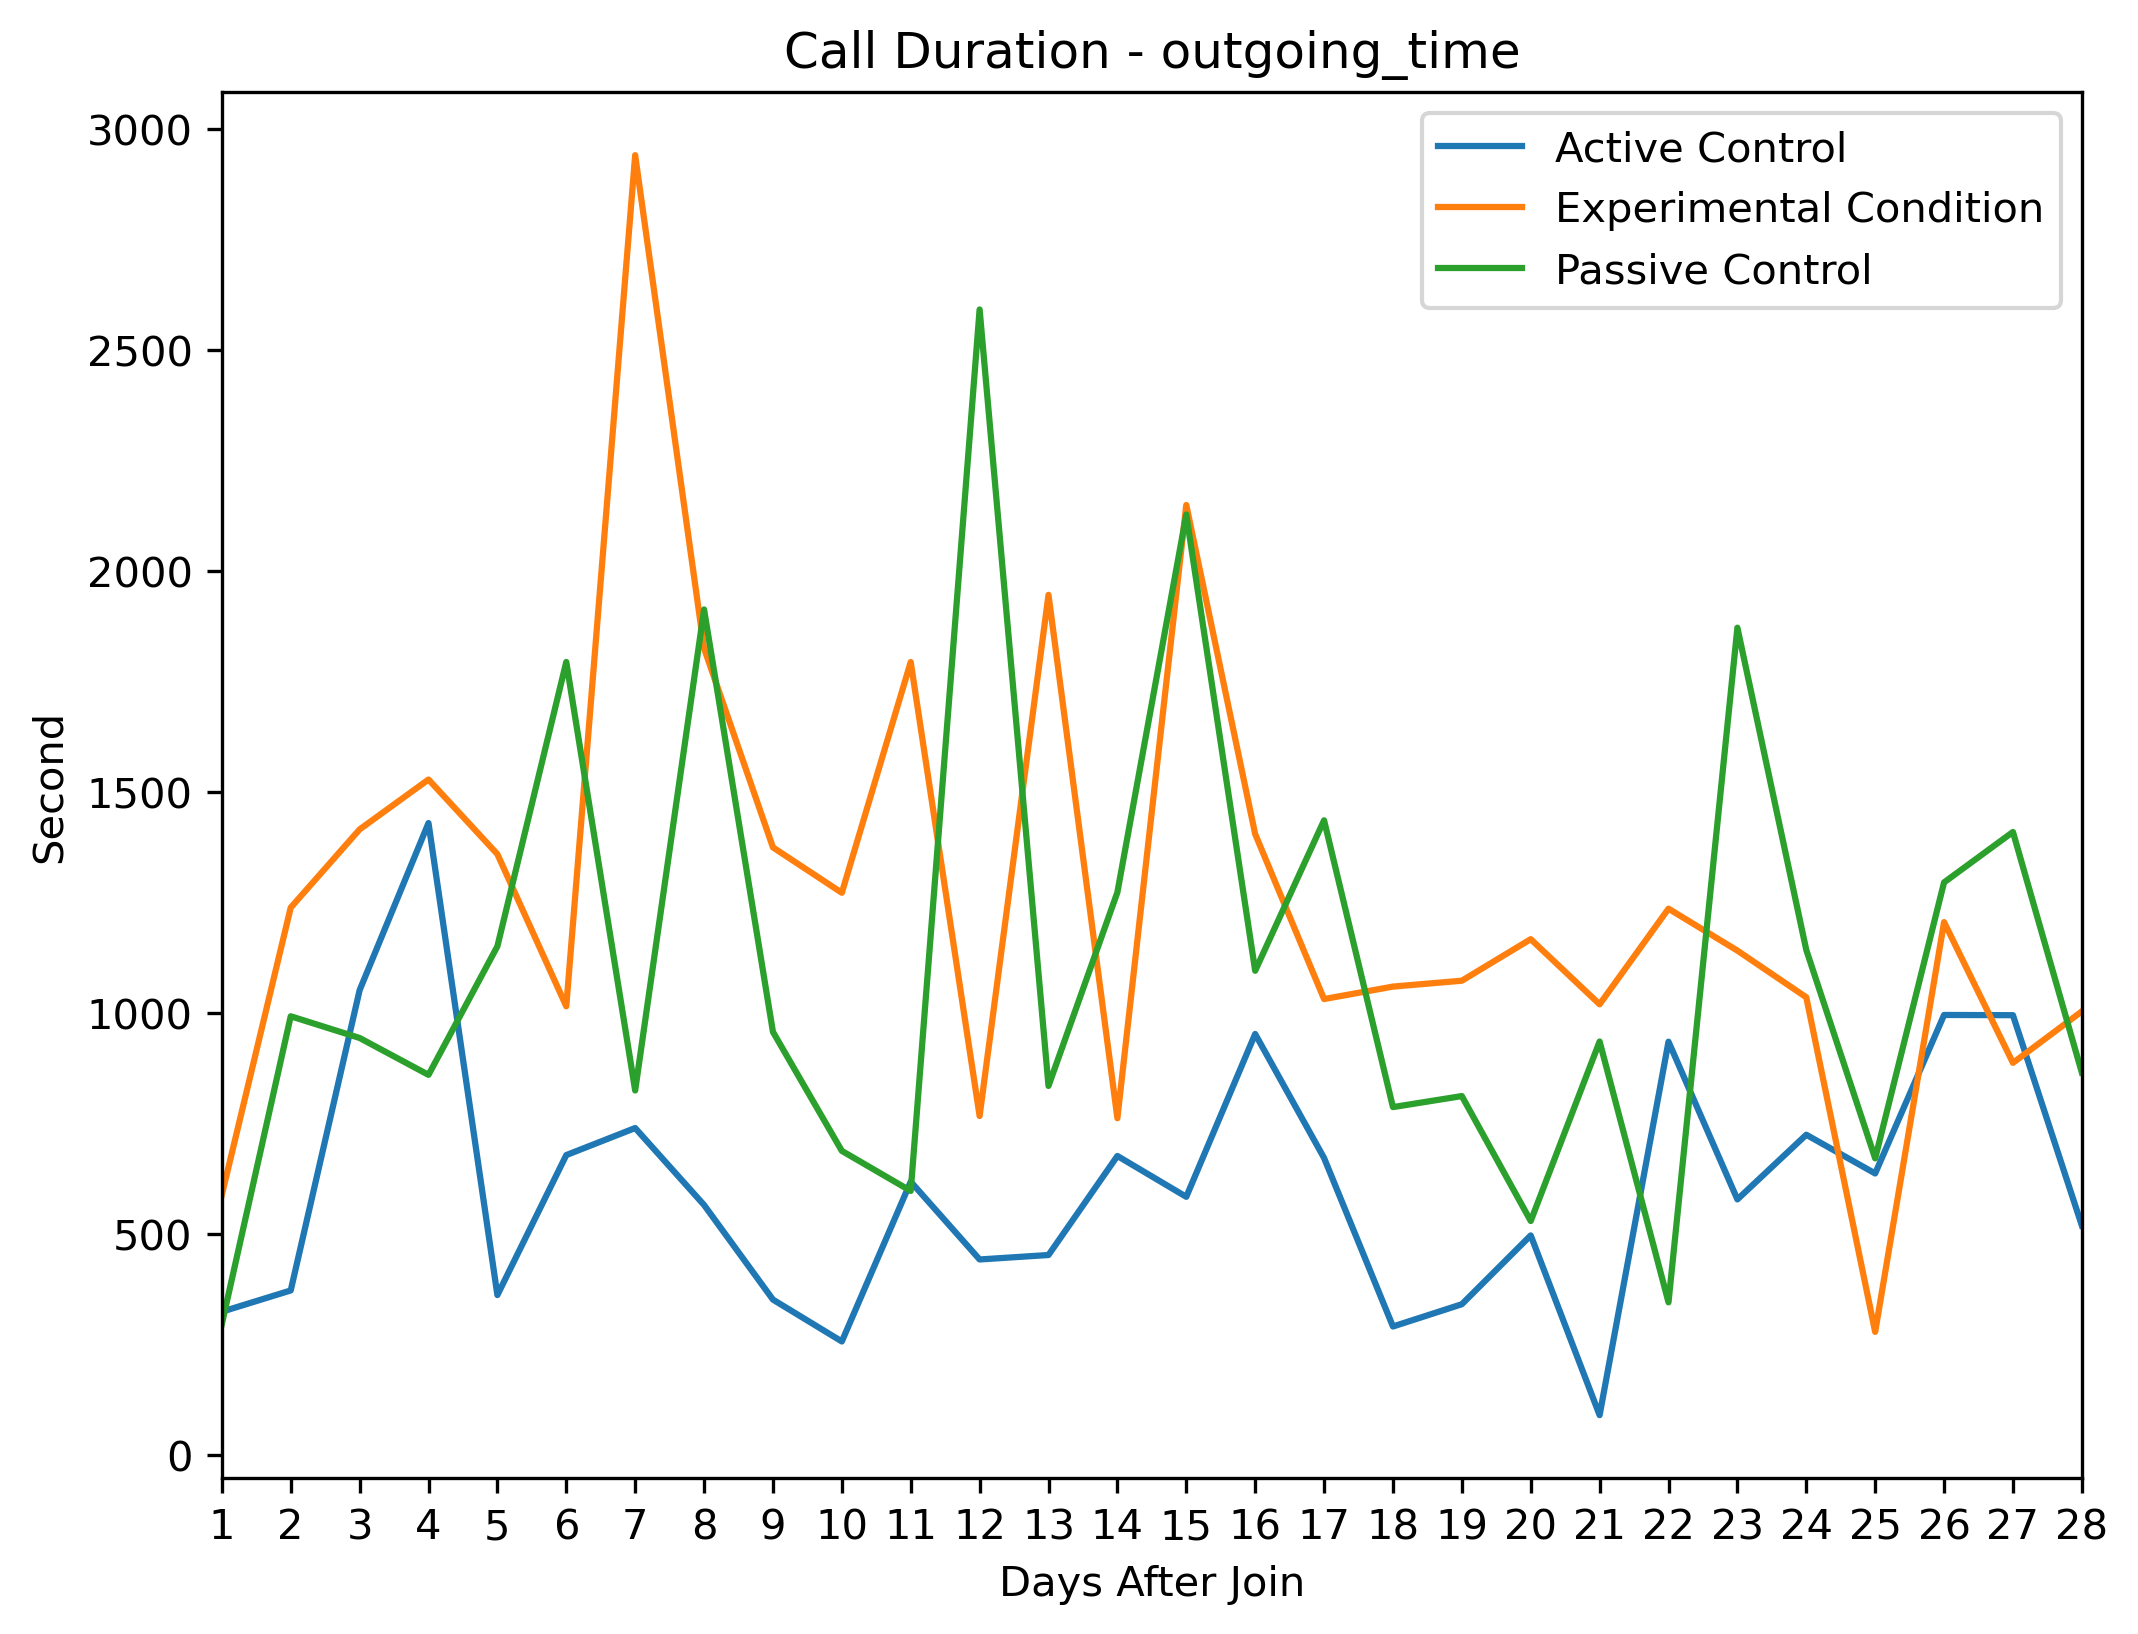

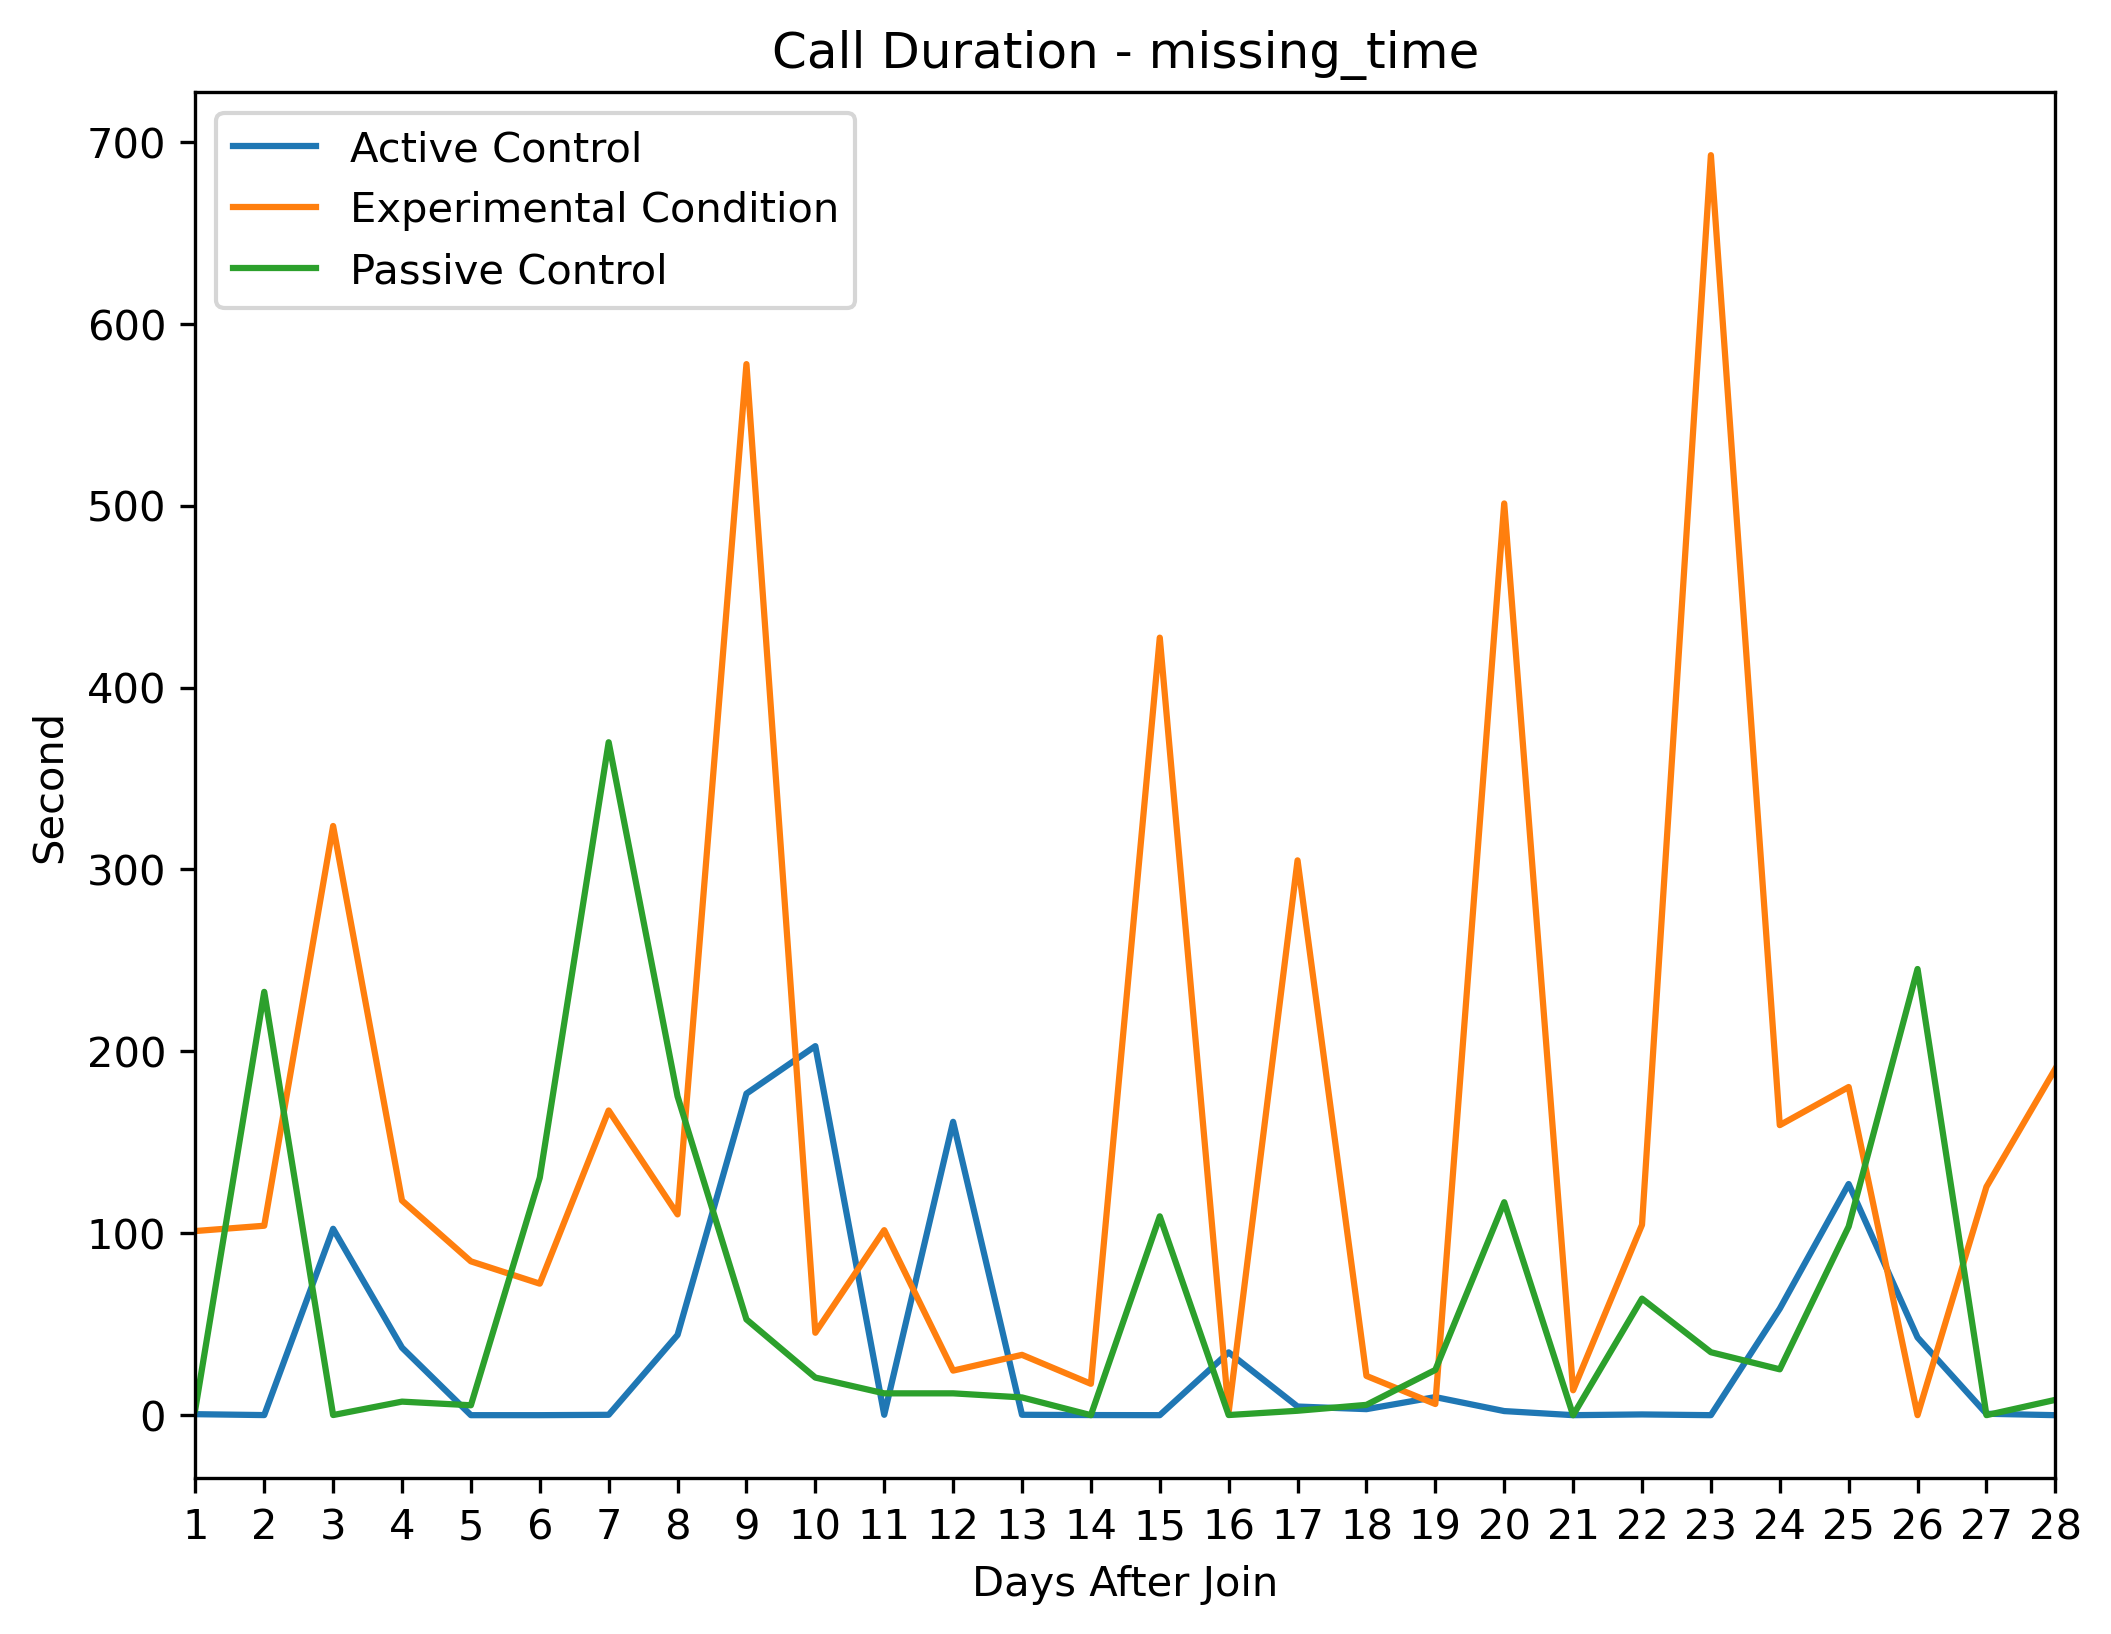

In [17]:
for feature in ['incoming_time','outgoing_time','missing_time']:
    plt.figure(figsize=(8, 6), dpi=300)
    for group in ['Active Control', 'Experimental Condition', 'Passive Control']:
        df_target = df_plot[df_plot['Group']==group]
        x = [i+1 for i in range(28)]
        y = df_target[feature].tolist()
        plt.plot(x,y,label = group)
    plt.xlim(1,28)
    plt.xticks([i+1 for i in range(28)],[i+1 for i in range(28)])
    plt.title("Call Duration - "+feature)
    plt.xlabel("Days After Join")
    plt.ylabel('Second')
    plt.legend()
    plt.show()

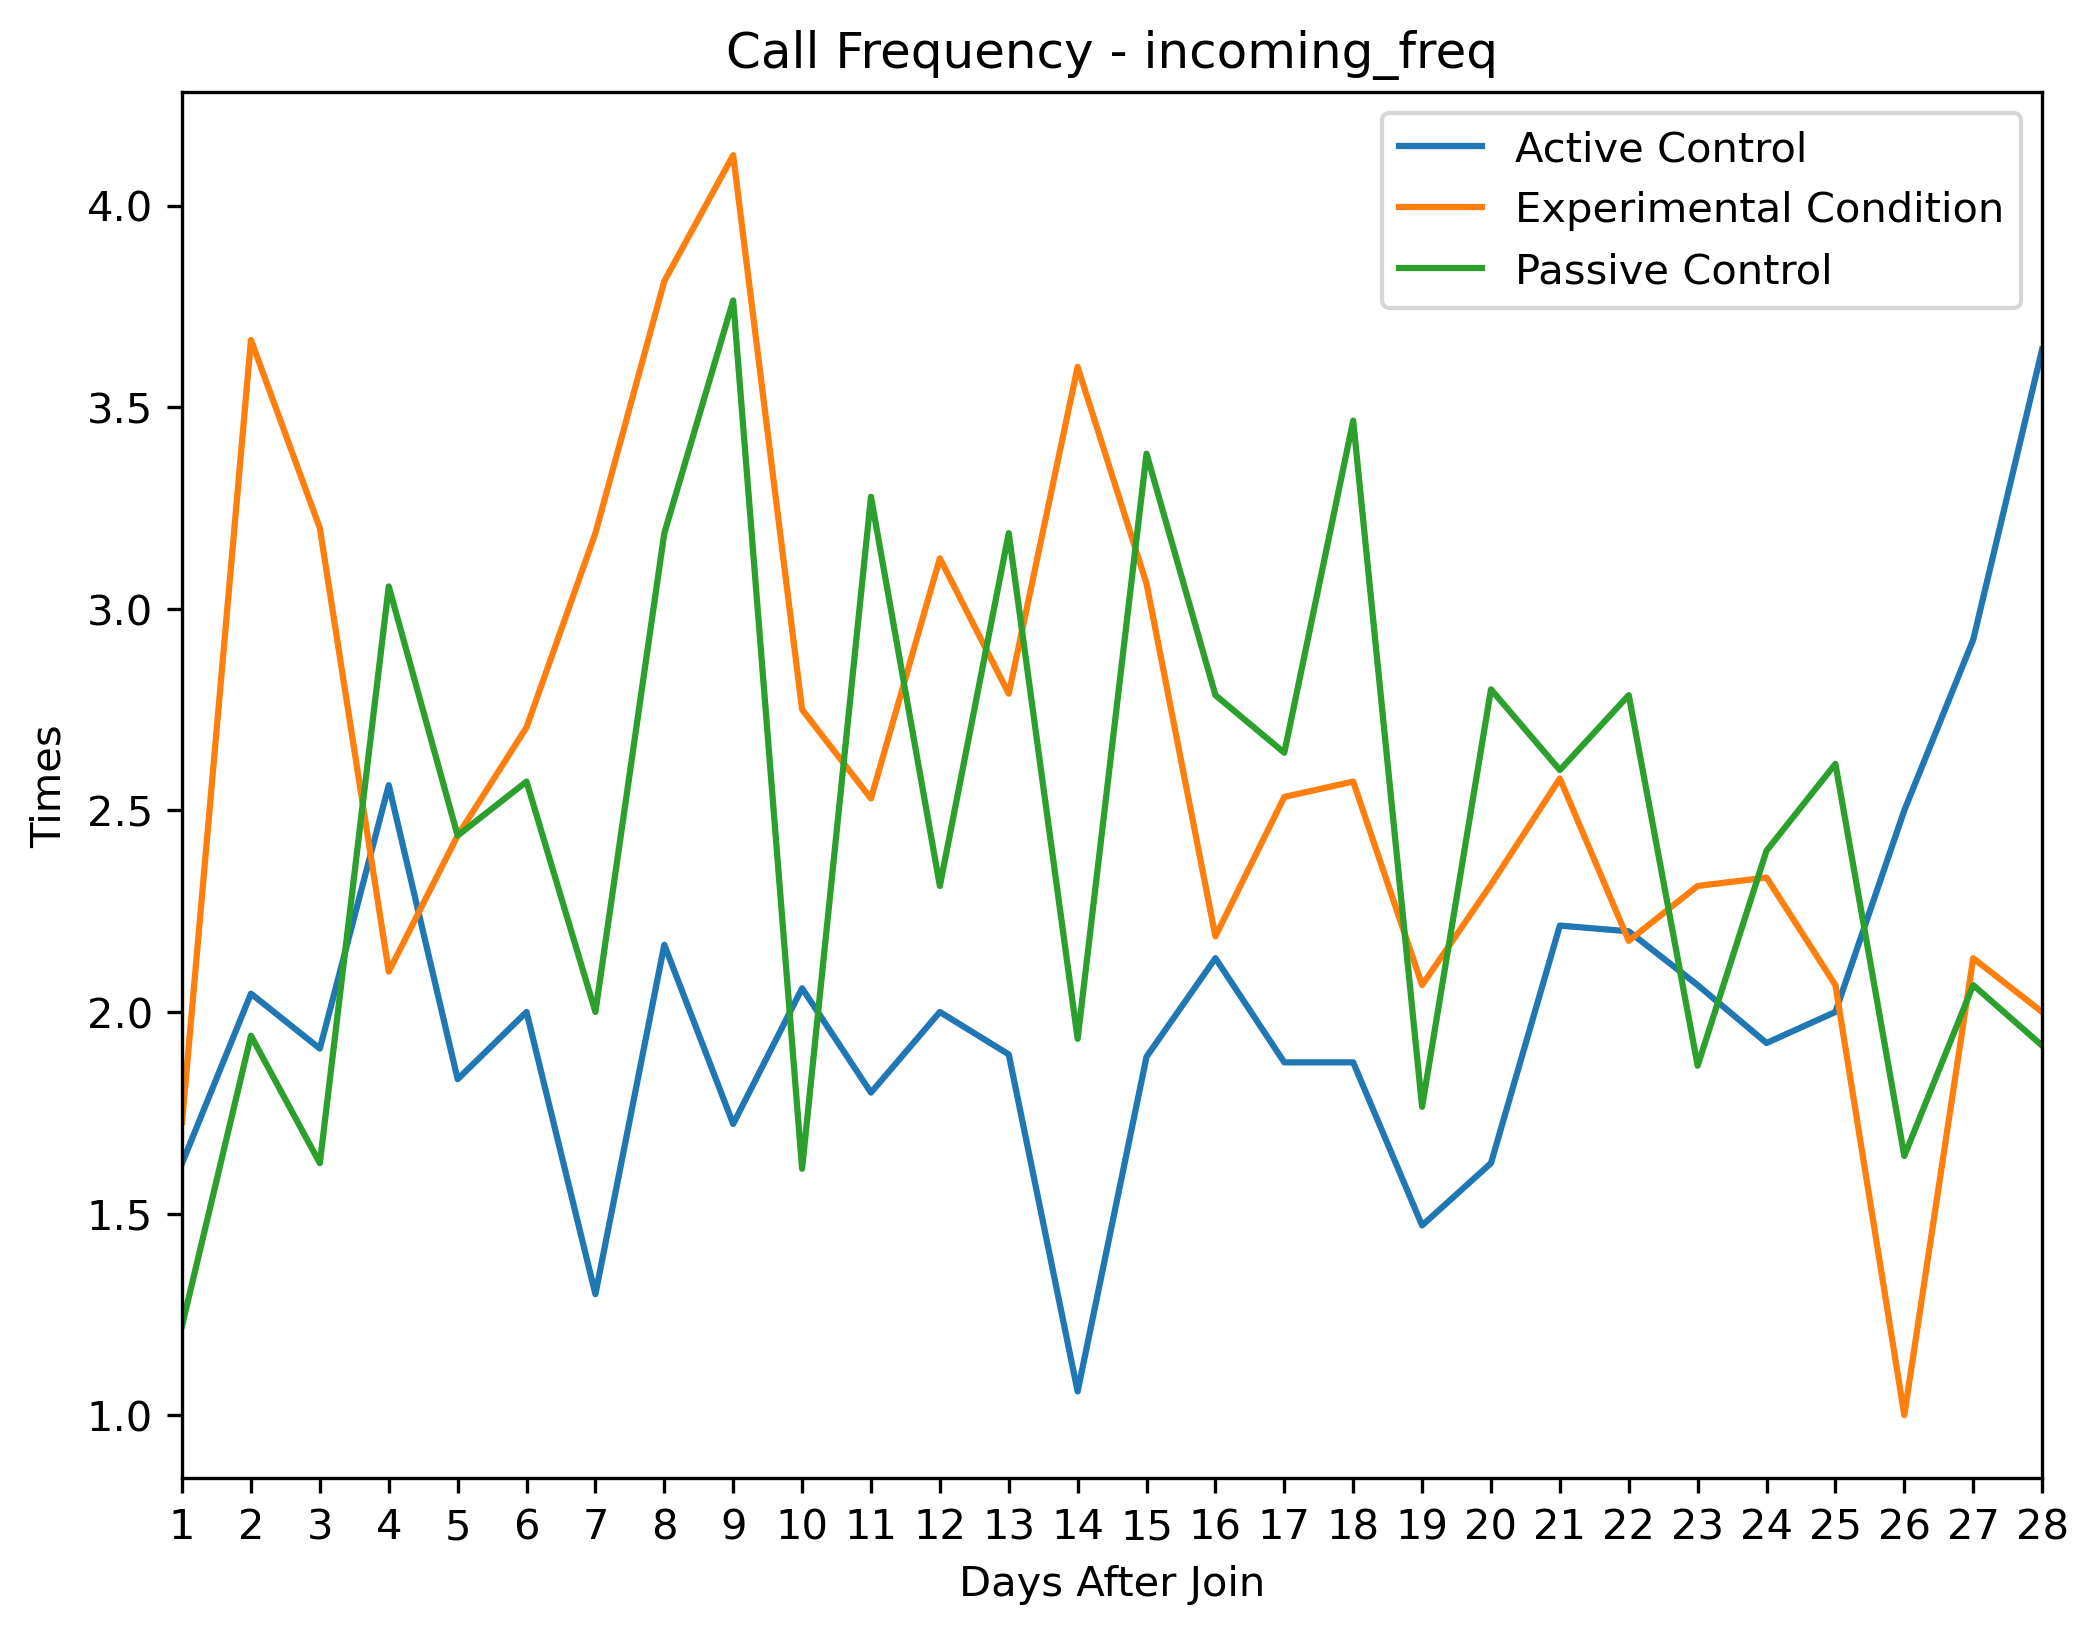

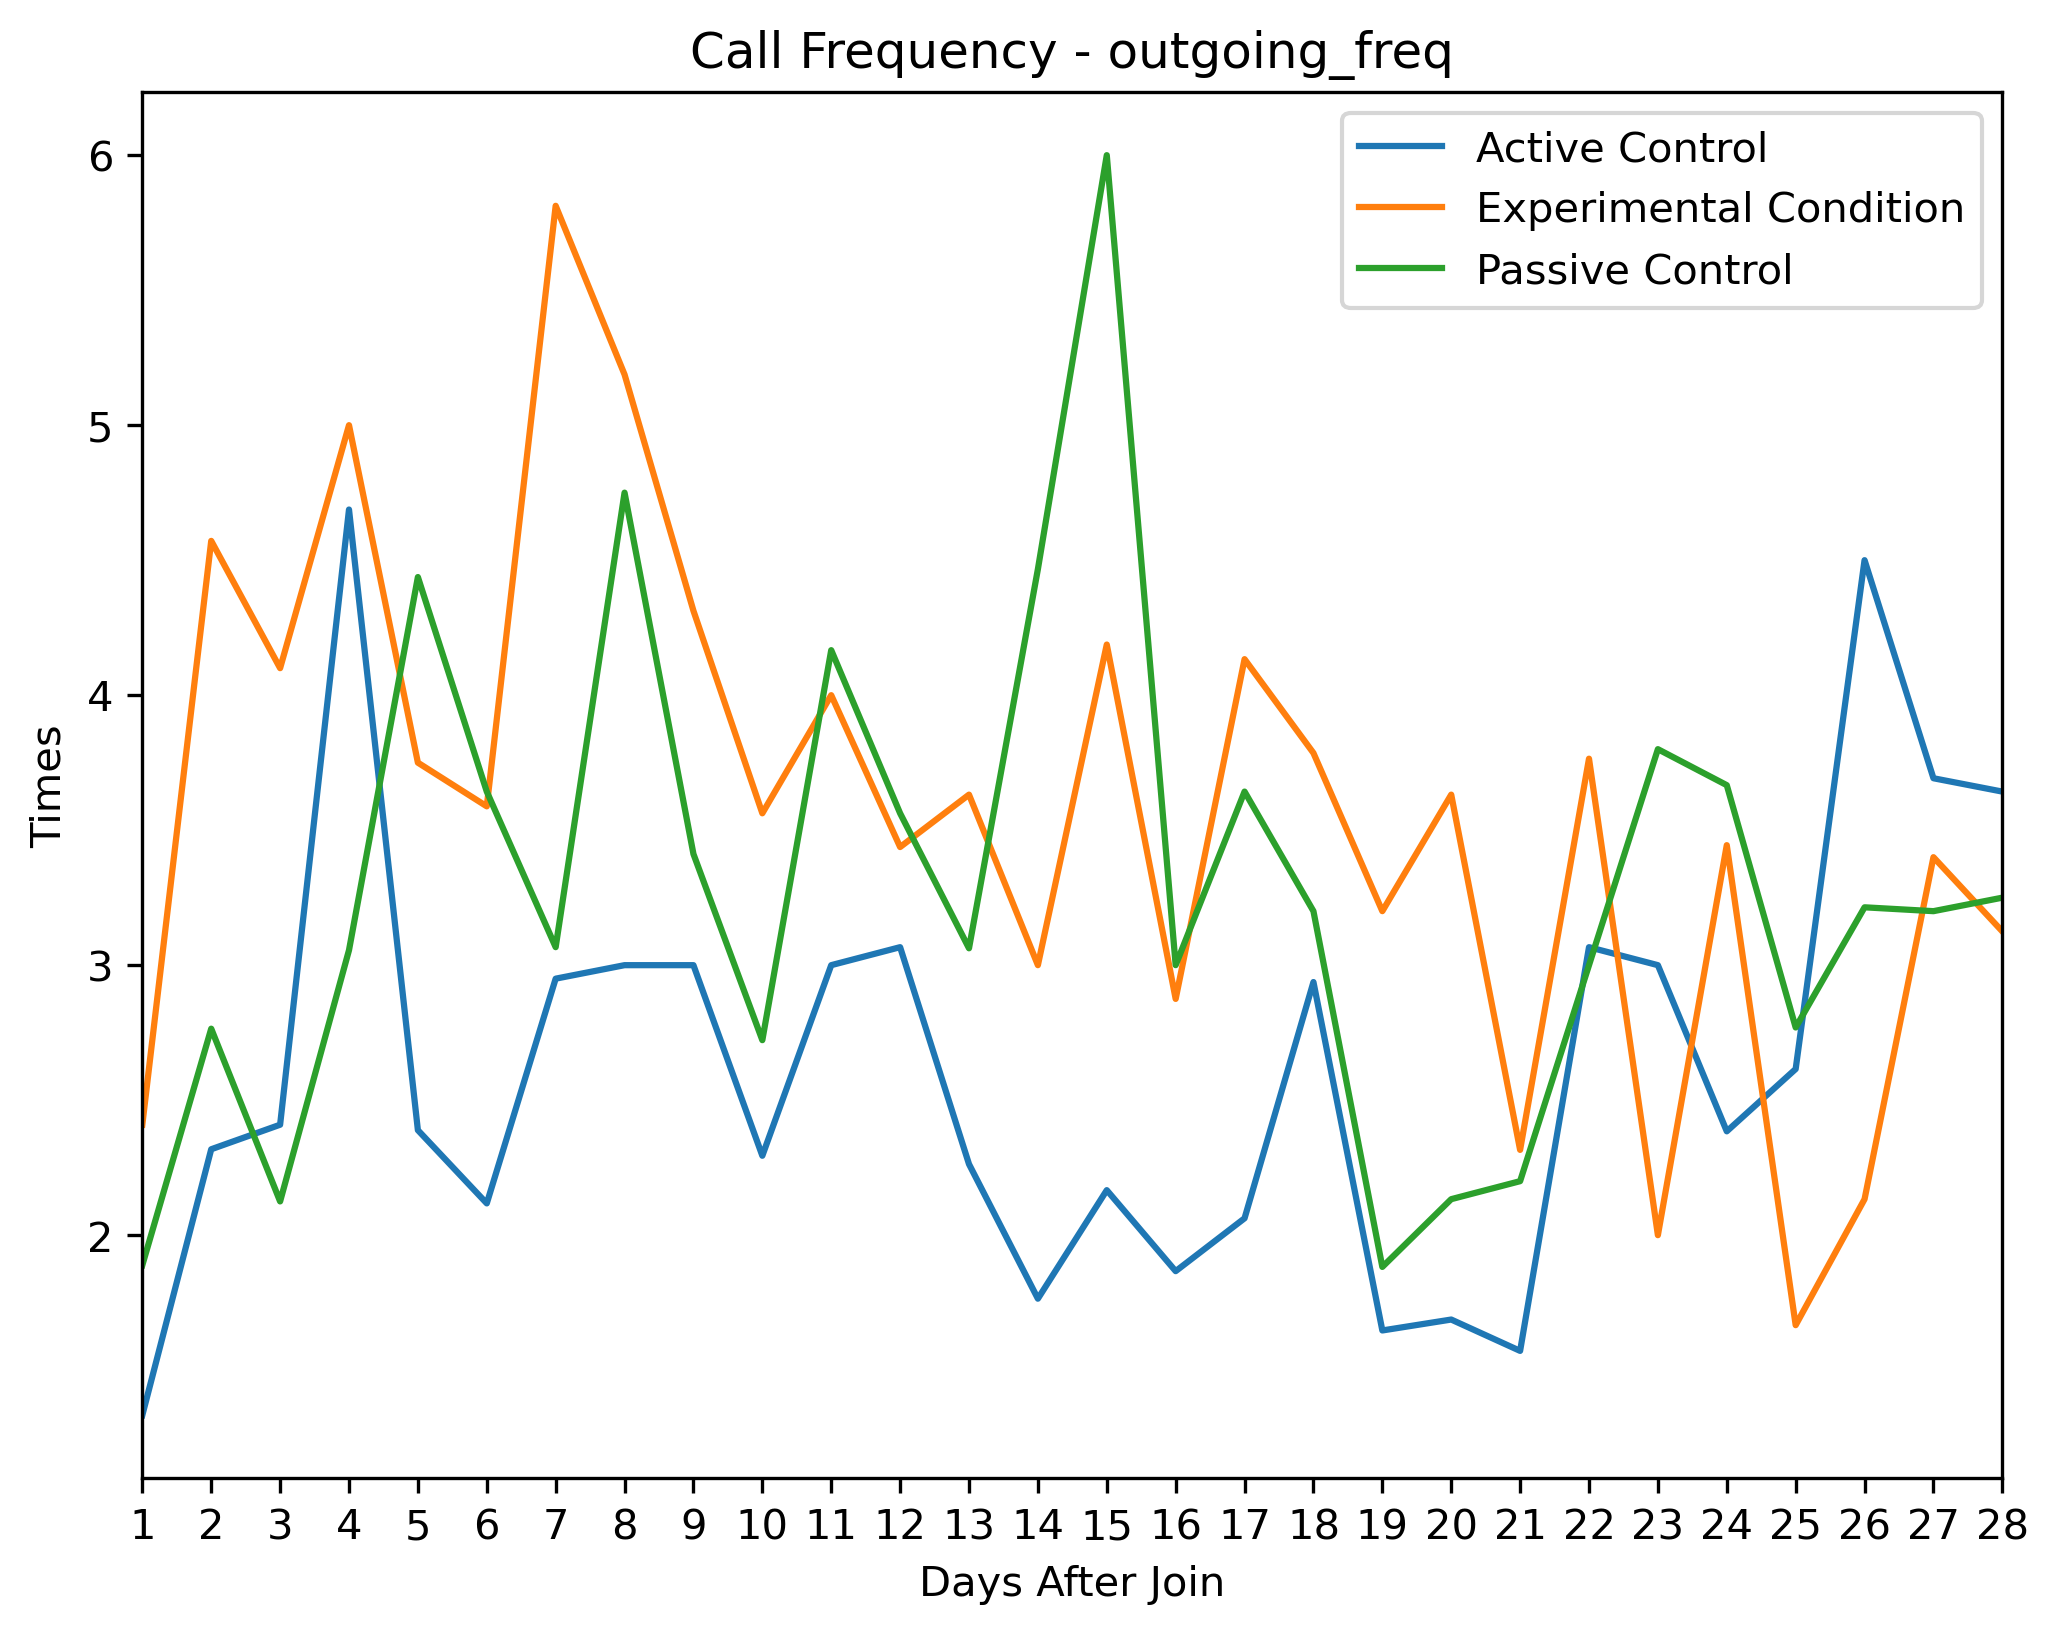

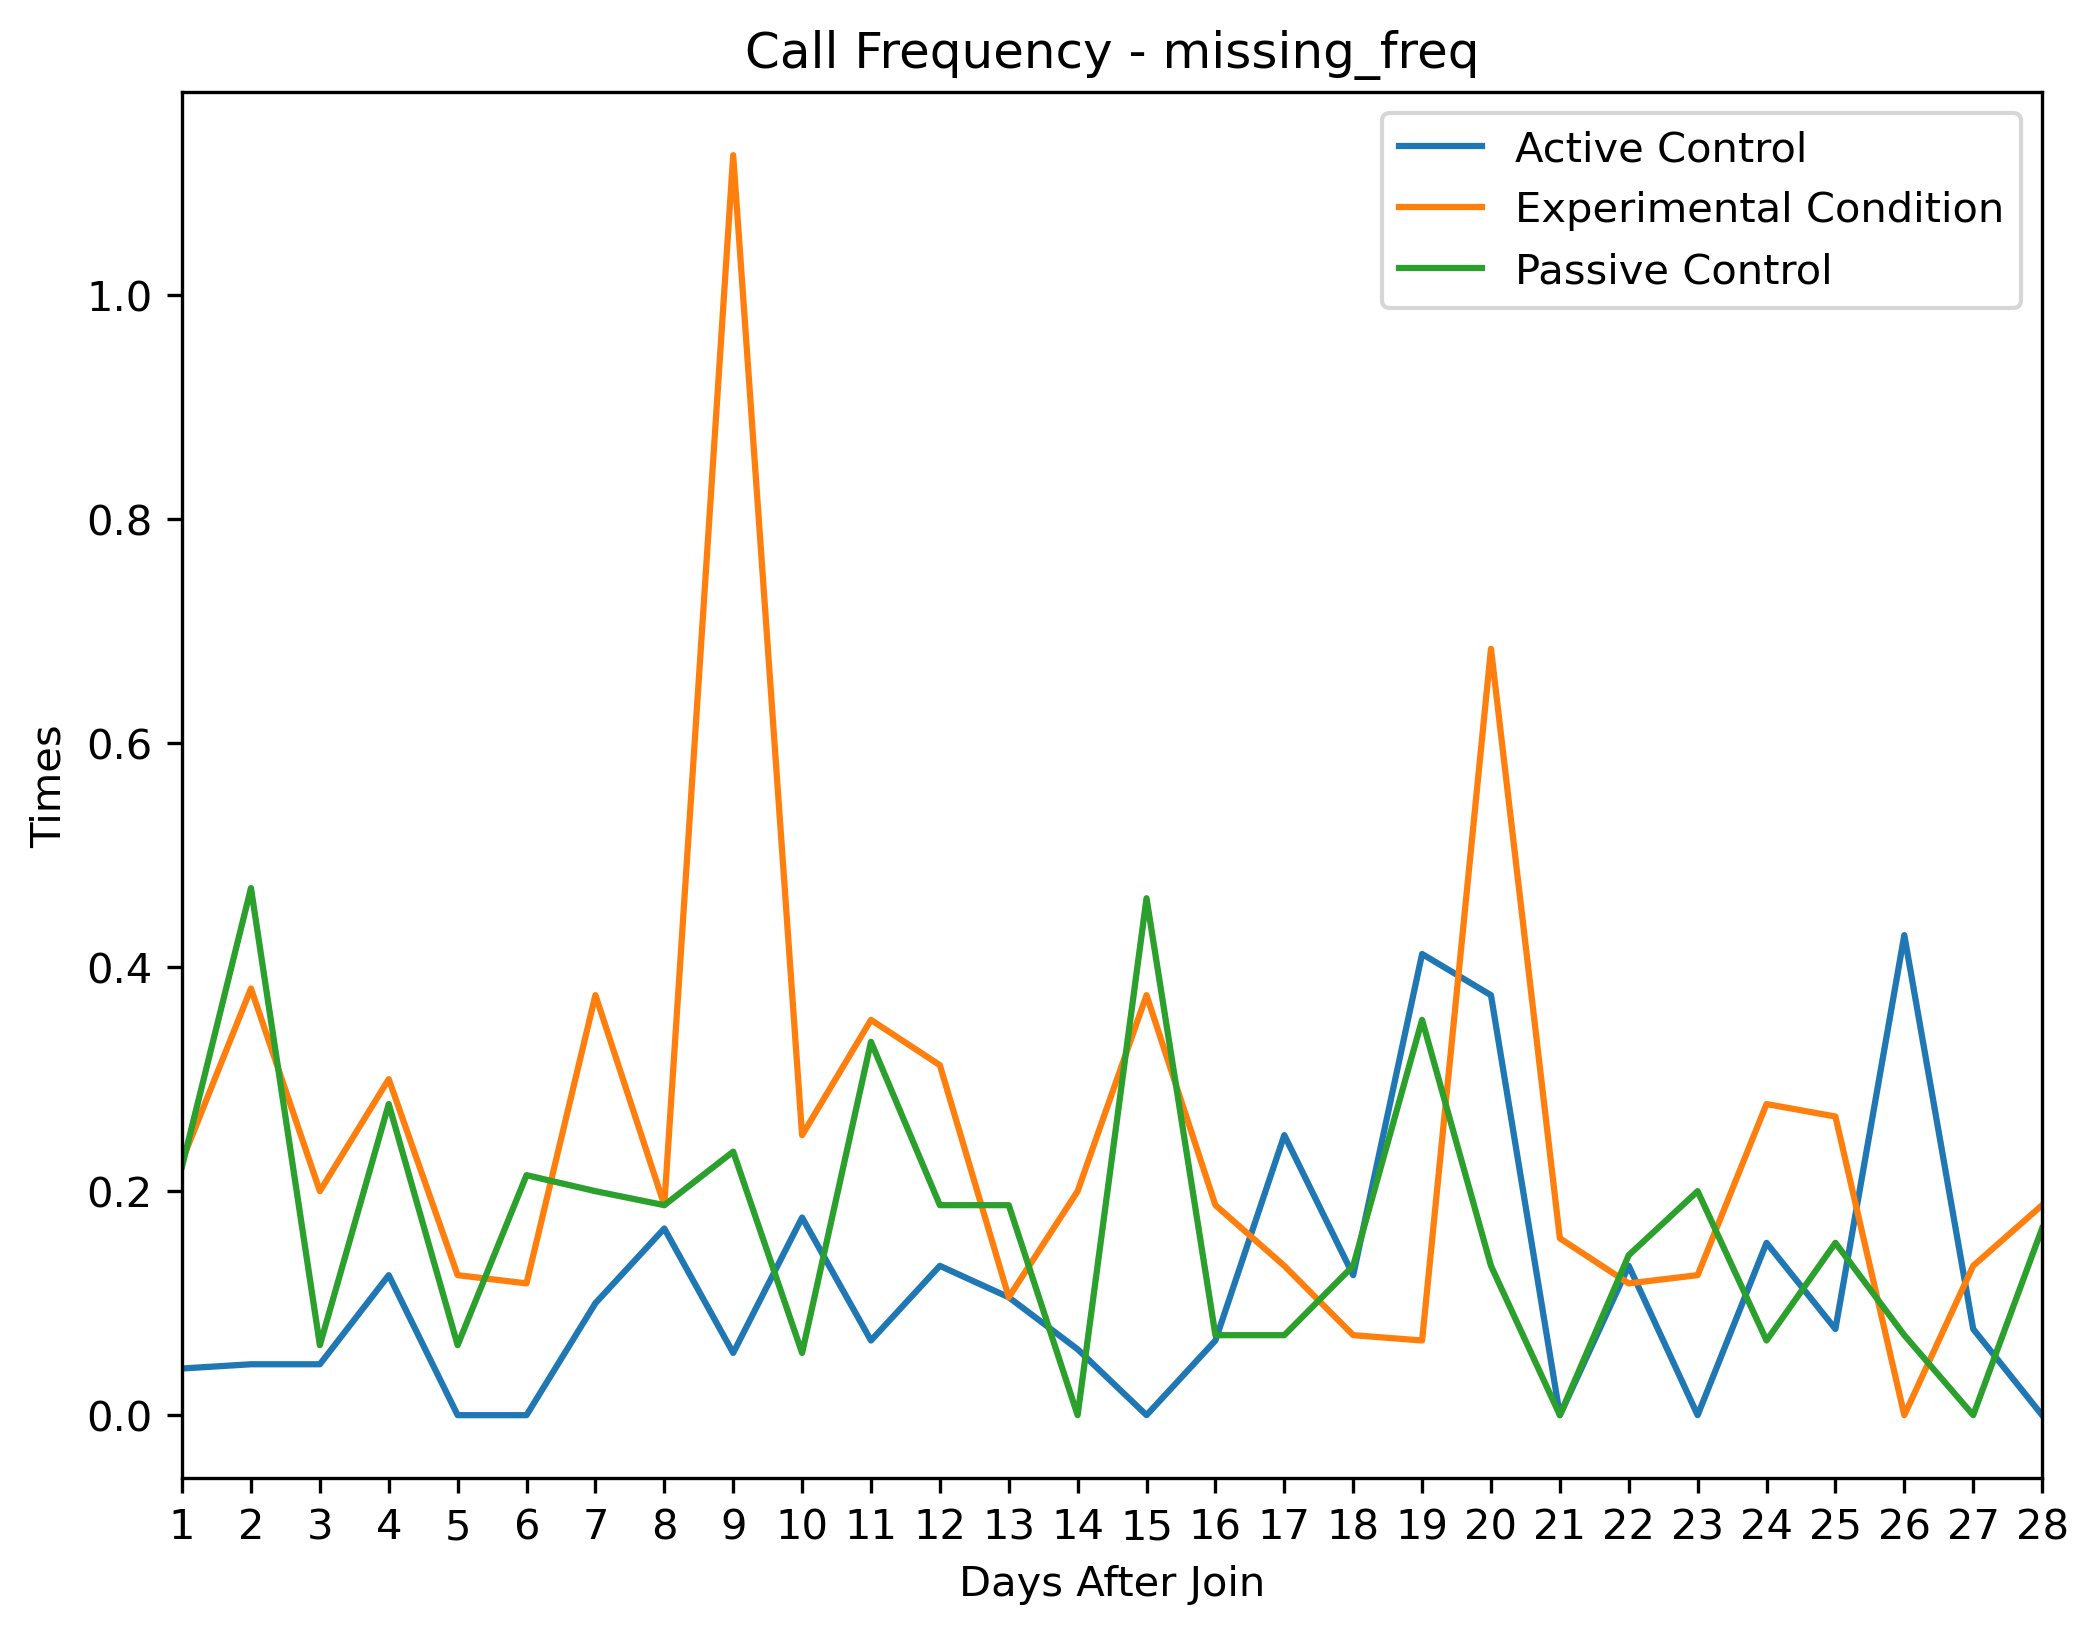

In [18]:
for feature in ['incoming_freq','outgoing_freq','missing_freq']:
    plt.figure(figsize=(8, 6), dpi=300)
    for group in ['Active Control', 'Experimental Condition', 'Passive Control']:
        df_target = df_plot[df_plot['Group']==group]
        x = [i+1 for i in range(28)]
        y = df_target[feature].tolist()
        plt.plot(x,y,label = group)
    plt.xlim(1,28)
    plt.xticks([i+1 for i in range(28)],[i+1 for i in range(28)])
    plt.title("Call Frequency - "+feature)
    plt.xlabel("Days After Join")
    plt.ylabel('Times')
    plt.legend()
    plt.show()